<a href="https://colab.research.google.com/github/addamit/py-howtos/blob/master/berttopic_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# !pip install datasets
# !pip install umap-learn
# !pip install hdbscan
# !pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
abstracts[:2], titles[:2]

(['  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n',
  '  In this paper we present the creation of an Arabic version of Automated\nSpeech Recognition System (ASR). This system is based on the open source\nSphinx-4, from the Carnegie Mellon University. Which is a speech recognition\nsystem based on discrete hidden Markov models (HMMs). We investigate the\nchanges that must be made to the model to adapt Arabic voice recognition.\n  Keywords: Speech recognition, Acoustic 

In [5]:
from sentence_transformers import SentenceTransformer
# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [7]:
# Check the dimensions of the resulting embeddings
embeddings.shape


(44949, 384)

In [10]:
from umap import UMAP
# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
 n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
reduced_embeddings.shape

(44949, 5)

In [13]:
from hdbscan import HDBSCAN
# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
 min_cluster_size=50, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_
# How many clusters did we generate?
len(set(clusters))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


150

In [21]:
len(clusters)

44949

In [24]:
min(clusters), max(clusters)

(-1, 148)

In [16]:
import numpy as np
# Print first three documents in cluster 0
cluster = 10
for index in np.where(clusters==cluster)[0][:3]:
 print(abstracts[index][:300] + "... \n")

  Financial statements contain quantitative information and manager's
subjective evaluation of firm's financial status. Using information released in
U.S. 10-K filings. Both qualitative and quantitative appraisals are crucial for
quality financial decisions. To extract such opinioned statements from... 

  We show that power-law analyses of financial commentaries from newspaper
web-sites can be used to identify stock market bubbles, supplementing
traditional volatility analyses. Using a four-year corpus of 17,713 online,
finance-related articles (10M+ words) from the Financial Times, the New York
Ti... 

  Using a corpus of over 17,000 financial news reports (involving over 10M
words), we perform an analysis of the argument-distributions of the UP- and
DOWN-verbs used to describe movements of indices, stocks, and shares. Using
measures of the overlap in the argument distributions of these verbs and
... 



In [26]:
import pandas as pd
# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
 n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)
# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]
# Select outliers and non-outliers (clusters)
# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [20]:
df.head(5)

x          y                                              title  \
0  4.571338  12.045630  Introduction to Arabic Speech Recognition Usin...   
1  4.567767  12.015672  Arabic Speech Recognition System using CMU-Sph...   
2  4.406608  11.113841  On the Development of Text Input Method - Less...   
3  0.649060  10.813931  Network statistics on early English Syntax: St...   
4  4.087434   8.817277  Segmentation and Context of Literary and Music...   

  cluster  
0      -1  
1      -1  
2      -1  
3      -1  
4      17

(-7.463608884811402,
 11.407711172103882,
 -1.1912264376878738,
 16.967825546860695)

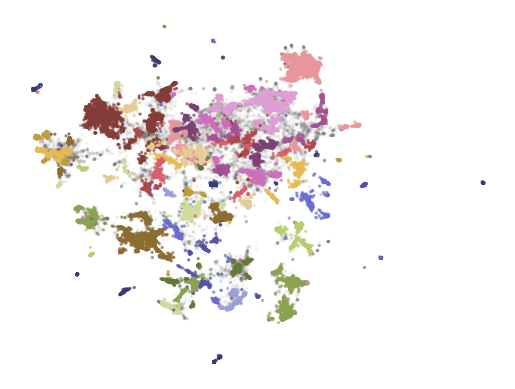

In [27]:
import matplotlib.pyplot as plt
# Plot outliers and non-outliers separately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
 clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
 alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")

In [30]:
from bertopic import BERTopic
# Train our model with our previously defined models
topic_model = BERTopic(
 embedding_model=embedding_model,
 umap_model=umap_model,
 hdbscan_model=hdbscan_model,
 verbose=True
).fit(abstracts, embeddings)

2025-02-24 11:59:20,258 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-24 12:00:30,557 - BERTopic - Dimensionality - Completed ✓
2025-02-24 12:00:30,559 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-24 12:00:36,731 - BERTopic - Cluster - Completed ✓
2025-02-24 12:00:36,753 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-24 12:00:42,296 - BERTopic - Representation - Completed ✓


In [31]:
topic_model.get_topic_info()

Topic  Count                                      Name  \
0       -1  14551                          -1_the_of_and_to   
1        0   2224            0_question_qa_questions_answer   
2        1   2050              1_speech_asr_recognition_end   
3        2   1520     2_medical_clinical_biomedical_patient   
4        3    964            3_translation_nmt_machine_bleu   
..     ...    ...                                       ...   
145    144     53       144_gans_gan_adversarial_generation   
146    145     52      145_backdoor_attacks_attack_triggers   
147    146     51      146_counseling_mental_therapy_health   
148    147     51  147_multimodal_modality_fusion_sentiment   
149    148     51    148_coherence_discourse_paragraph_text   

                                        Representation  \
0    [the, of, and, to, in, we, language, for, that...   
1    [question, qa, questions, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [medical, clinical, biomedical, patient, healt...   
4    [translation, nmt, machine, bleu, neural, engl...   
..                                                 ...   
145  [gans, gan, adversarial, generation, generativ...   
146  [backdoor, attacks, attack, triggers, poisoned...   
147  [counseling, mental, therapy, health, psychoth...   
148  [multimodal, modality, fusion, sentiment, moda...   
149  [coherence, discourse, paragraph, text, cohesi...   

                                   Representative_Docs  
0    [  Knowledge-enhanced pre-trained models for l...  
1    [  In open question answering (QA), the answer...  
2    [  Voice Assistants such as Alexa, Siri, and G...  
3    [  Biomedical Named Entity Recognition (NER) i...  
4    [  Neural Machine Translation (NMT) models ach...  
..                                                 ...  
145  [  Text generation is of particular interest i...  
146  [  The prompt-based learning paradigm, which b...  
147  [  Mental health care poses an increasingly se...  
148  [  Multimodal machine learning is a core resea...  
149  [  While there has been significant progress t...  

[150 rows x 5 columns]

In [32]:
topic_model.get_topic(0)

[('question', 0.02145681593936748),
 ('qa', 0.01588839959163033),
 ('questions', 0.01585843213647822),
 ('answer', 0.015727085079070776),
 ('answering', 0.014908290491091976),
 ('answers', 0.00989025089046151),
 ('retrieval', 0.009562015670680156),
 ('comprehension', 0.007837863662310648),
 ('reading', 0.007314196296894196),
 ('the', 0.0063958267469293485)]

In [33]:
topic_model.find_topics("topic modeling")

([22, -1, 2, 45, 30],
 [0.95497566, 0.911328, 0.9087179, 0.90749735, 0.90506303])

In [34]:
topic_model.get_topic(22)

[('topic', 0.06945617465332493),
 ('topics', 0.036023179433915774),
 ('lda', 0.01661929568243725),
 ('latent', 0.013983559515945656),
 ('document', 0.012634641415039357),
 ('documents', 0.012620262980522618),
 ('modeling', 0.012530857445661283),
 ('dirichlet', 0.010302387745128845),
 ('word', 0.008892079799744539),
 ('allocation', 0.008109142901468164)]

In [36]:
topic_model.topics_[titles.index("BERTopic: Neural topic modeling with a class-based TF-IDF procedure")]

22

In [37]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
 titles,
 reduced_embeddings=reduced_embeddings,
 width=1200,
 hide_annotations=True
)
# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [38]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()
# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)
# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()